<a href="https://colab.research.google.com/github/AnujaJogdand/Image-Classification/blob/main/Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting SoH and RUL of Li-ion batteries using deep learning concepts**


---



NASA battery
degradation data set is used for this analysis. 

The model evaluation is based on Root
Mean Squared Error, Mean Squared Error, Mean Absolute Percentage Error and Mean
Absolute Error. 

In [ ]:
#This command line is used for auto completion of code
%config Completer.use_jedi = False

In [ ]:
# This is needed so that the plotted figures appear embedded in this notebook
%matplotlib inline
# Checking tensorflow version
!pip show tensorflow
# Downloading the file 
!wget -cq https://ti.arc.nasa.gov/c/5 -O naza.zip
# Unzipping the file
!unzip -qqo naza.zip -d battery_data

Name: tensorflow
Version: 2.9.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: termcolor, wrapt, six, grpcio, tensorflow-estimator, google-pasta, astunparse, setuptools, absl-py, flatbuffers, gast, tensorboard, keras-preprocessing, numpy, packaging, keras, protobuf, libclang, tensorflow-io-gcs-filesystem, h5py, typing-extensions, opt-einsum
Required-by: kapre


# **Importing necessary libraries**

In [ ]:
# datetime is a built-in Python module to display current date and time.
import datetime
import numpy as np
import pandas as pd
# SciPy has many modules, classes, and functions available to read data from and write data to a variety of file formats
from scipy.io import loadmat # To load matlab file in collab. scipy uses numpy underneath
from sklearn.preprocessing import MinMaxScaler #Transform features by scaling each feature to a given range
from sklearn.metrics import mean_squared_error
from sklearn import metrics # For measuring accuracy score
import matplotlib.pyplot as plt
# Used for plotting graphs
import seaborn as sns # seaborn uses matplotlib underneath

#**Collecting the data related to the discharge of the battery(B0005)**

In [ ]:
def load_data(battery):
  mat = loadmat('battery_data/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  # print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.013979             24.544752       -1.9982         3.030  53.781  
4         -2.011144             24.731385       -1.9982         3.011  71.922  


,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


**Plotting the graph between capacity and cycle for battery B0005**


---



The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle.

Text(0.5, 1.0, 'Discharge B0005')

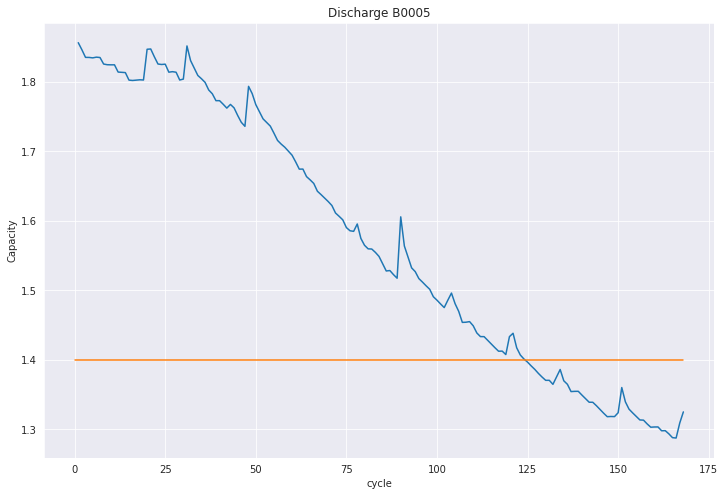

In [ ]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
# The horizontal line represents the threshold (1.4Ahr)
# related to what can be considered the end of the battery's life cycle.
plt.plot([0.,len(capacity)], [1.4, 1.4]) # batteries reached end of life criteria which was a 30% fade in rated capacity (from 2Ahr to 1.4Ahr)
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

# **Calculating SoH of the battery**


---


It is necessary to calculate the SoH of the battery, since this is the data that will be predicted using the deep learning model.

In [ ]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0] # capacity of 1st cycle
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


A graph of the SoH is made for each cycle.
The horizontal line represents the threshold of 70% in which the battery already fulfills its life cycle and it is advisable to make the change.

Text(0.5, 1.0, 'Discharge B0005')

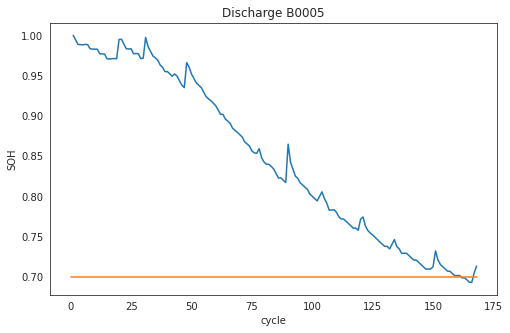

In [ ]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

# **SoH Prediction**


---



The dataset is prepared in such a way that it can be used by Tensorflow in the training phase, for this, two structures are created corresponding to the input and output expected to be obtained. For the input data:

Battery capacity
Voltage
Current
Temperature
Charging voltage
Charging current
Instant of time (from the start of the download)

For the output data, the SoH of the battery is calculated and in both input and output cases, the values are normalized to a range of values between [0-1] using MinMaxScalar.

**Training the data**

In [ ]:
C = dataset['capacity'][0] #capacity of 1st cycle
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1)) # Feature Scaling
train_dataset = sc.fit_transform(train_dataset) # Calculating mean and variance of each feature and transforming all the features using it.
# print(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
# RELU is rectified linear unit activation function.
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 64        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


3 dense layers and one dropout, and one of the ADAM type is used as optimizer.

Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problems involving a lot of data or parameters. It requires less memory and is efficient

ADAM Algorithm helps in training deep learning model by taking continuous averages and predicts the data in the future in a better way.


---



**Fitting the model**

In [ ]:
model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 4s 2ms/step - loss: 0.1244
Epoch 2/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0345
Epoch 3/50
2012/2012 [==============================] - 5s 2ms/step - loss: 0.0329
Epoch 4/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0325
Epoch 5/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0327
Epoch 6/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0324
Epoch 7/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0322
Epoch 8/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0323
Epoch 9/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0323
Epoch 10/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0323
Epoch 11/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0323
Epoch 12/50
2012/2012 [==============================] - 3s 2ms/step - loss: 0.0322
E

**Calculating SoH of B0006 Battery**

In [ ]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.008730             24.515123       -1.9990         3.045  53.781  
4         -2.013381             24.676053       -1.9990         3.026  71.922  
   cy

#**Predicting the SoH of B0006 Using pretrained model**

In [ ]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

1572/1572 [==============================] - 2s 1ms/step
(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.935426
1      2  0.994990  0.932799
2      3  0.989185  0.929723
3      4  0.989165  0.929712
4      5  0.982898  0.926375
5      6  0.989467  0.929872
6      7  0.989075  0.929663
7      8  0.967304  0.918068
8      9  0.966997  0.917905
9     10  0.961625  0.915048
Root Mean Square Error:  0.07916638813941908


#**Graph between predicted SoH and original values of SoH for B0006**

Text(0.5, 1.0, 'Discharge B0006')

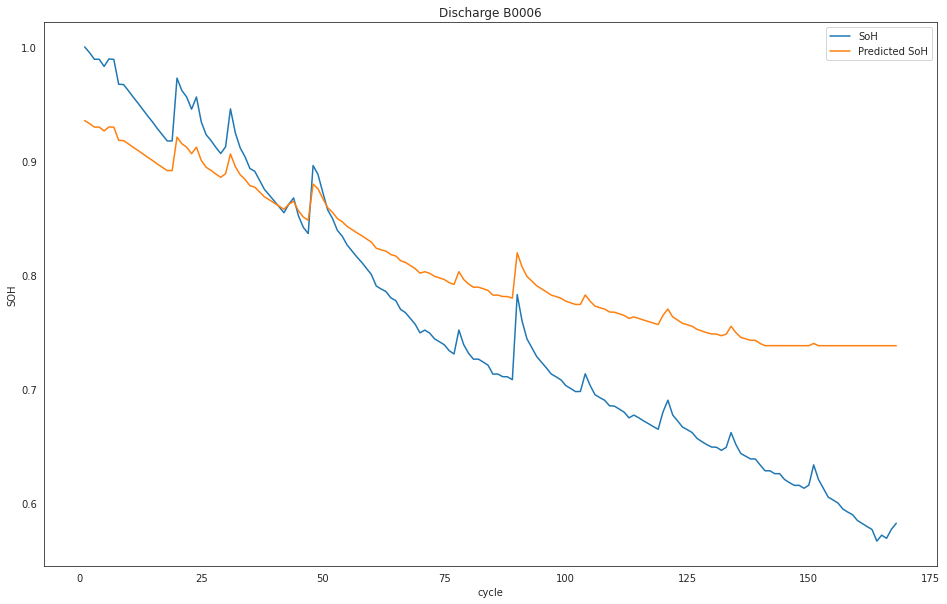

In [ ]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')



---



---

#**RUL Prediction**

In [ ]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
# print(X_train.shape)
# print(y_train)
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
# print(X_train.shape)

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
